# Evaluating our model's predictions based on current home values (2019-10-01)

## Import necessary packages

In [56]:
import pandas as pd
import matplotlib.pyplot as plt
from python.predictor import melt_data, model_price
from fbprophet import Prophet as proph
plt.style.use('fivethirtyeight')

In [24]:
def plot_models(df, stats_df, zipcodes, title):
    """
    Models each zipcode and plots them on a single axis.
    
    Args: 
        df: a data frame with columns [RegionID, RegionName, City, State, Metro,
        CountyName, SizeRank, 1996-04, 1996-05, 1996-06... 2018-02, 2018-03, 2018-04]
        stats_df: a data frame with columns [zipcode, 2018-04-01, minimum, min_roi, 
        expected, expected_roi, maximum, max_roi]
        zipcode: zipcode
    Returns:
        figure with the data from the zipcodes plotted, dictonary of forecasts
    """
    palette = plt.get_cmap('Dark2')
    forecasts = {}
    fig, ax = plt.subplots(figsize=(15,8))
    for index, zipcode in enumerate(zipcodes):
        color = palette(index)
        zip_history_df = create_zip_df(df, zipcode, '2005-04-01', '2018-04-01')
        model, forecast, zipcode = model_price(df, zipcode, '2005-04-01', '2018-04-01')
        forecasts[zipcode] = forecast
        zip_data = df.loc[df['RegionName'] == zipcode]
        stats_data = stats_df.loc[stats_df['zipcode'] == zipcode]
        label = (f"{zip_data['City'].values[0]}"
                 + f", {zip_data['State'].values[0]}"
                )
        ax.plot(zip_history_df['ds'], zip_history_df['y'], color='k', alpha=0.5)
        ax.plot_date(forecast['ds'], forecast['yhat'], color=color, alpha=.75, label=label) #plot forecast
        ax.fill_between(forecast['ds'], forecast['yhat_lower'], forecast['yhat_upper'],
                       color=color, alpha=.25) #plot forecast range
        
    fig.suptitle(f'Recommended Zipcodes for Real Estate Investment: {title}')
    ax.legend(loc='upper left')
    ax.set_ylabel('price')
    ax.set_xlabel('year')
    return forecasts

In [14]:
def create_zip_df(df, zipcode, start, end):
    df = melt_data(df.loc[df['RegionName'] == zipcode])
    df = df.reset_index()
    df.columns = ['ds', 'y']
    data_df = df.loc[(df['ds'] > start) & (df['ds'] < end)]
    return data_df

In [15]:
home_vals_2019 = pd.DataFrame([[29601, 188700], [75234, 247100], [75224, 181600], 
                               [27601, 324400], [75235, 195800], [33563, 194300],
                               [32211, 146500], [7302, 879300], [33404, 242700], 
                               [95210, 262900], [48506, 25400], [33936, 141600],
                               [33068, 218200]
                              ], 
                              columns=['zipcode', 'price'])

In [16]:
home_vals_2019

,zipcode,price
0,29601,188700
1,75234,247100
2,75224,181600
3,27601,324400
4,75235,195800
5,33563,194300
6,32211,146500
7,7302,879300
8,33404,242700
9,95210,262900


In [17]:
home_vals_2019.to_csv('raw_data/home_vals_2019', index=False)

In [88]:
def plot_model_vs_real(zipcodes, forecasts, true_vals, date):
    """Plots the forecasts and true value for each zipcode passed
    
    Args:
        zipcodes: an iterable of zipcodes
        forecasts: a dictionary with zipcodes as keys, forecast dataframes as values
        true_vals: a data frame with columns zipcode, price
        date: date for forecasting in format YYYY-MM-01
    
    Returns:
    """
    fig, ax = plt.subplots()
    for zipcode in zipcodes:
        forecast = forecasts[zipcode]
        zip_label = str(int(zipcode))
        ax.plot([zip_label, zip_label], 
                [forecast.loc[forecast['ds'] == date, 'yhat_lower'].values[0], 
                 forecast.loc[forecast['ds'] == date, 'yhat_upper'].values[0]],
                color = 'b', alpha = .5
               )
        ax.scatter(zip_label, forecast.loc[forecast['ds'] == date, 'yhat'].values[0],
                  color = 'b')
        ax.scatter([zip_label], [true_vals.loc[true_vals['zipcode'] == zipcode, 'price'].values[0]],
                  color = 'k', marker = 'x')
        
    ax.set_ylim((0, 900000))
    ax.set_title(f"{date} Snapshot of Forecasted and Real Values")
    ax.set_ylabel('median home price')
    ax.set_xlabel('zipcode')
    fig.plot();
        
    

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seaso

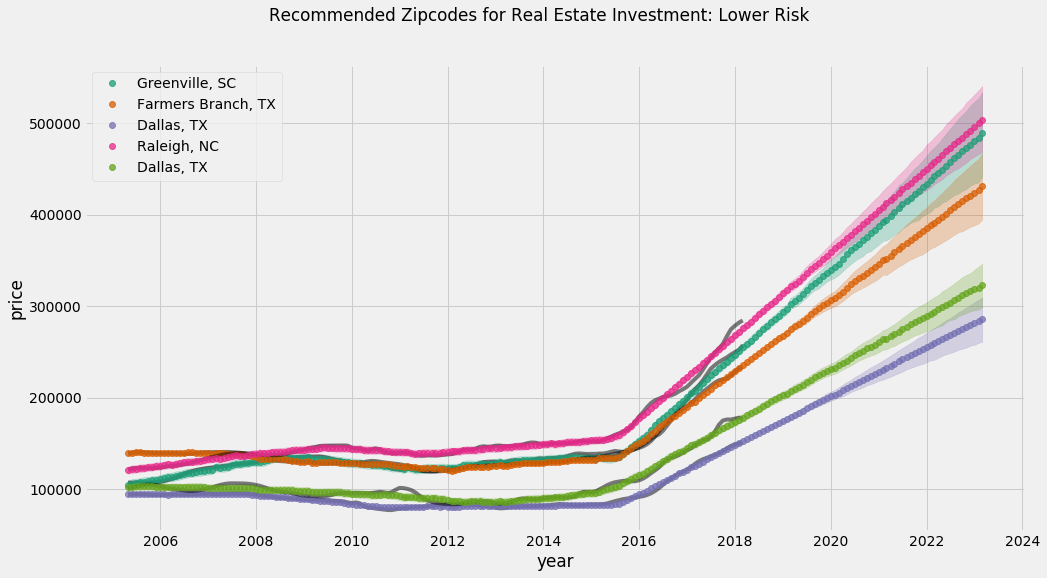

In [80]:
all_df = pd.read_csv('raw_data/zillow_data.csv')
no_nan_df = pd.concat([all_df['RegionName'], all_df.loc[:, '2005-04': '2018-04']], axis=1).dropna()
stats_df = pd.read_csv('raw_data/stats.csv')
filtered_stats_df = stats_df.loc[stats_df['zipcode'].isin(no_nan_df['RegionName'])]
conservative5 = filtered_stats_df.nlargest(5, 'min_roi')
moderate5 = filtered_stats_df.nlargest(5, 'expected_roi')
potential5 = filtered_stats_df.nlargest(5, 'max_roi')
forecasts = plot_models(all_df, stats_df, conservative5['zipcode'], 'Lower Risk')

In [73]:
f = forecasts[29601]

In [75]:
f.loc[f['ds'] == '2019-10-01', ['ds','yhat_lower', 'yhat_upper']]

,ds,yhat_lower,yhat_upper
173,2019-10-01,318832.546903,338176.950886


INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should

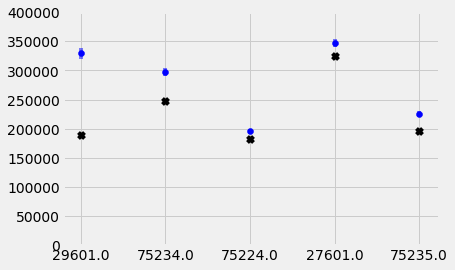

In [79]:

plot_model_vs_real(conservative5['zipcode'], forecasts, home_vals_2019, '2019-10-01')

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seaso

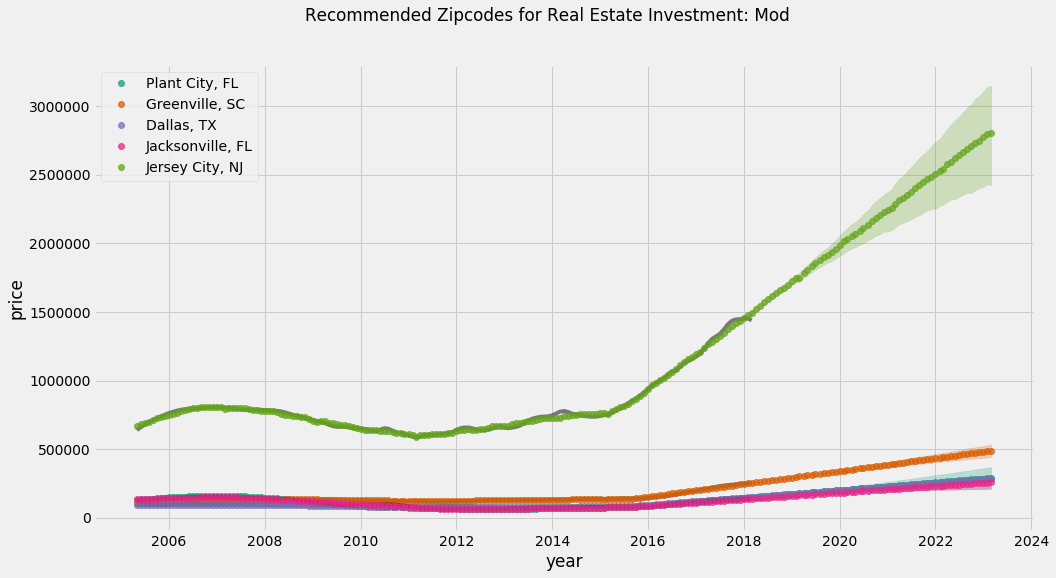

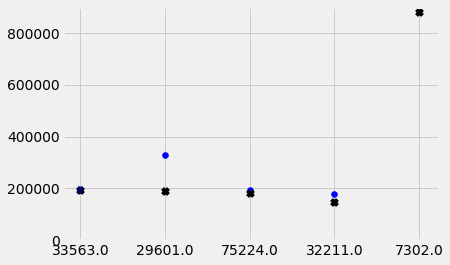

In [85]:
forecasts = plot_models(all_df, stats_df, moderate5['zipcode'], 'Mod')
plot_model_vs_real(moderate5['zipcode'], forecasts, home_vals_2019, '2019-10-01')

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seaso

AttributeError: 'Figure' object has no attribute 'plot'

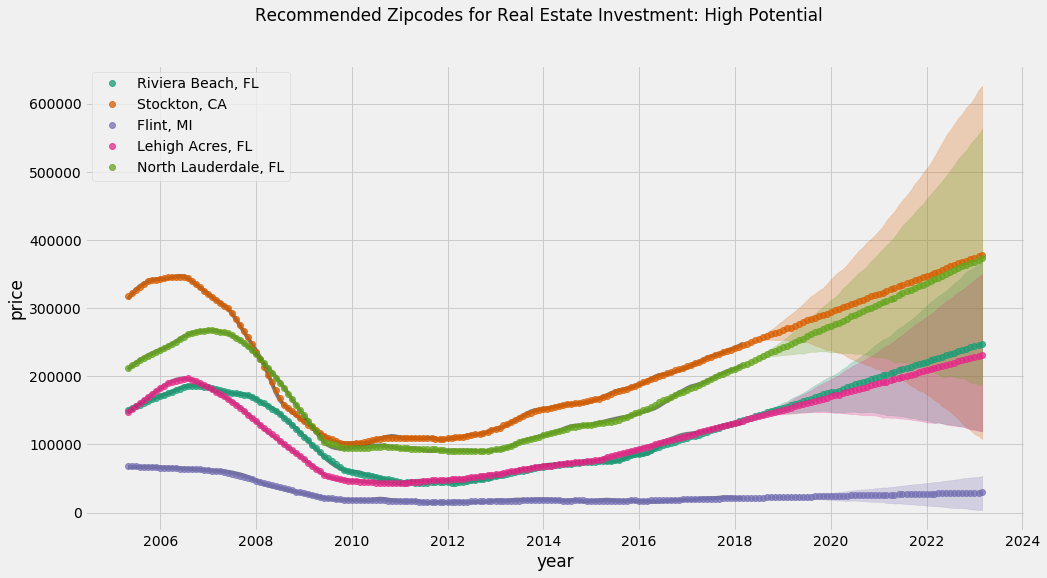

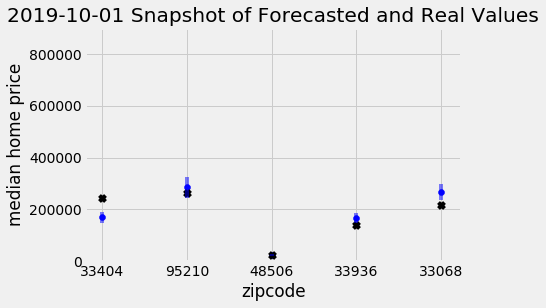

In [89]:
forecasts = plot_models(all_df, stats_df, potential5['zipcode'], 'High Potential')
plot_model_vs_real(potential5['zipcode'], forecasts, home_vals_2019, '2019-10-01')